In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

plt.style.use('ggplot')

In [2]:
nc_state = pd.read_csv("../date/Info/non_canonical_state.csv", index_col=0)

In [3]:
# Dizionario per convertire i nomi dei geni in ID
sens_df = pd.read_csv("../date/omics_data/gene_effect/Crispr_sens_clusters.csv", index_col=0)
gene_info = pd.read_csv("../date/Info/gene_info.csv", index_col=0)
gene_conv_dict = dict(zip(gene_info['gene_name'], gene_info.index))

## Depmap vs Propensity

In [4]:
# Geni selezionati
with open("../date/result_all/selected_genes.txt", "r") as f:
    selected_genes = [line.strip() for line in f] # converto in lista

In [5]:
# Compute correlations

corr_matrix = np.zeros((len(sens_df.columns), 2)) # Correlazioni
pval_matrix = np.zeros((len(sens_df.columns), 2)) # P-values
n_matrix = np.zeros((len(sens_df.columns), 2)) # Numero di sample

# Calcolo della correlazione
for idx, col in enumerate(sens_df.columns):
    try:
        valid_data = pd.concat([nc_state[["propensity", "flux intensity"]], sens_df[col]], axis=1).dropna()

        if not valid_data.empty:
            # Salva numero di sample validi
            n_matrix[idx, 0] = valid_data.shape[0]
            n_matrix[idx, 1] = valid_data.shape[0]

            # Calcola Pearson
            corr_matrix[idx, 0], pval_matrix[idx, 0] = pearsonr(valid_data["propensity"], valid_data[col])
            corr_matrix[idx, 1], pval_matrix[idx, 1] = pearsonr(valid_data["flux intensity"], valid_data[col])
    except Exception as e:
        print(f"Errore con la colonna {col}: {e}")

    if idx % 4000 == 0:
        print(f"Processed {idx} columns...")

corr_matrix_df = pd.DataFrame(corr_matrix, index=sens_df.columns, columns=["propensity", "flux intensity"])
pval_matrix_df = pd.DataFrame(pval_matrix, index=sens_df.columns, columns=["propensity", "flux intensity"])
n_matrix_df = pd.DataFrame(n_matrix, index=sens_df.columns, columns=["propensity", "flux intensity"])

# FDR correction
fdr_pvals_prop = multipletests(pval_matrix_df['propensity'], method='fdr_bh')[1] 
fdr_pvals_flux = multipletests(pval_matrix_df['flux intensity'], method='fdr_bh')[1]
pval_matrix_df["fdr_propensity"] = fdr_pvals_prop
pval_matrix_df["fdr_flux_intensity"] = fdr_pvals_flux

Processed 0 columns...
Processed 4000 columns...
Processed 8000 columns...
Processed 12000 columns...
Processed 16000 columns...
Errore con la colonna depMap ID: data type <class 'numpy.object_'> not inexact


In [8]:
propensity_corr = pd.DataFrame(corr_matrix_df["propensity"])
propensity_corr["fdr"] = pval_matrix_df["fdr_propensity"]
propensity_corr["n_samples"] = n_matrix_df["propensity"]
propensity_corr["ensembl_id"] = propensity_corr.index.map(gene_conv_dict)
print("Numero di geni:", len(propensity_corr))
propensity_corr.head()

Numero di geni: 18437


,propensity,fdr,n_samples,ensembl_id
A1BG,-0.035045,0.791043,346.0,ENSG00000121410
A1CF,0.080728,0.440226,346.0,ENSG00000148584
A2M,-0.012539,0.932687,346.0,ENSG00000175899
A2ML1,-0.139133,0.110371,346.0,ENSG00000166535
A3GALT2,0.010783,0.941132,346.0,ENSG00000184389


### Regplot

In [11]:
gene_list = ["TCF7L2", "CTNNB1", "KRAS", "PIK3CA", "PIK3C2A", "MAPK14", "MAP2K2", "MAPK1"]

In [12]:
sens_subset_df = sens_df[sens_df.columns[sens_df.columns.isin(gene_list)]]
sens_subset_df

,CTNNB1,KRAS,MAP2K2,MAPK1,MAPK14,PIK3C2A,PIK3CA,TCF7L2
NIHOVCAR3_OVARY,-0.164159,-0.343388,-0.169123,0.102870,-0.513289,0.131446,-0.390163,0.013525
HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.364811,-0.156136,-0.045996,0.019480,-0.406374,0.076940,-0.378921,0.017344
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.207304,-0.578951,0.075575,-0.008014,-0.199885,0.066130,-0.490770,0.005757
MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LS513_LARGE_INTESTINE,-1.006196,-2.126530,-0.044612,-0.196135,-0.253107,-0.129507,-0.625468,-0.773521
...,...,...,...,...,...,...,...,...
NCIH292_LUNG,0.061734,-0.295587,-0.135244,-0.118396,-0.159080,-0.114815,-0.590562,-0.162855
HCC1588_LUNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KOPN8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONOMAC1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.174647,-1.119576,0.028342,-0.151919,-0.404045,-0.116600,-0.813249,-0.060211


In [13]:
propensity_corr_sig = propensity_corr[propensity_corr["fdr"] < 0.05]
fdr_series = propensity_corr_sig["fdr"].sort_values(ascending=True)
fdr_series

depMap ID    0.000000e+00
TCF7L2       1.465100e-13
RAB10        1.900634e-13
DENND4C      1.900634e-13
PPA1         1.007083e-10
                 ...     
BABAM1       4.900815e-02
OTOP3        4.900815e-02
SIAH1        4.941744e-02
CHMP6        4.974405e-02
SLC38A6      4.979487e-02
Name: fdr, Length: 937, dtype: float64

In [24]:
propensity_corr_sig

,propensity,fdr,n_samples,ensembl_id
AARS2,-0.164121,0.045385,346.0,ENSG00000124608
ABHD3,0.166919,0.040879,346.0,ENSG00000158201
ABI1,0.184654,0.019611,346.0,ENSG00000136754
ABI3,-0.188096,0.016624,346.0,ENSG00000108798
ABT1,-0.197628,0.010141,346.0,ENSG00000146109
...,...,...,...,...
ZRANB1,0.208437,0.005633,346.0,ENSG00000019995
ZSWIM2,0.166715,0.041128,346.0,ENSG00000163012
ZYG11B,0.178467,0.026348,346.0,ENSG00000162378
depMap ID,0.000000,0.000000,513.0,NaN


In [14]:
propensity = nc_state["propensity"]

In [15]:
ordered_columns = ['CTNNB1', 'TCF7L2', 'KRAS', 'PIK3C2A', 'PIK3CA', 'MAP2K2', 'MAPK1', 'MAPK14']
sens_subset_df = sens_subset_df[ordered_columns]

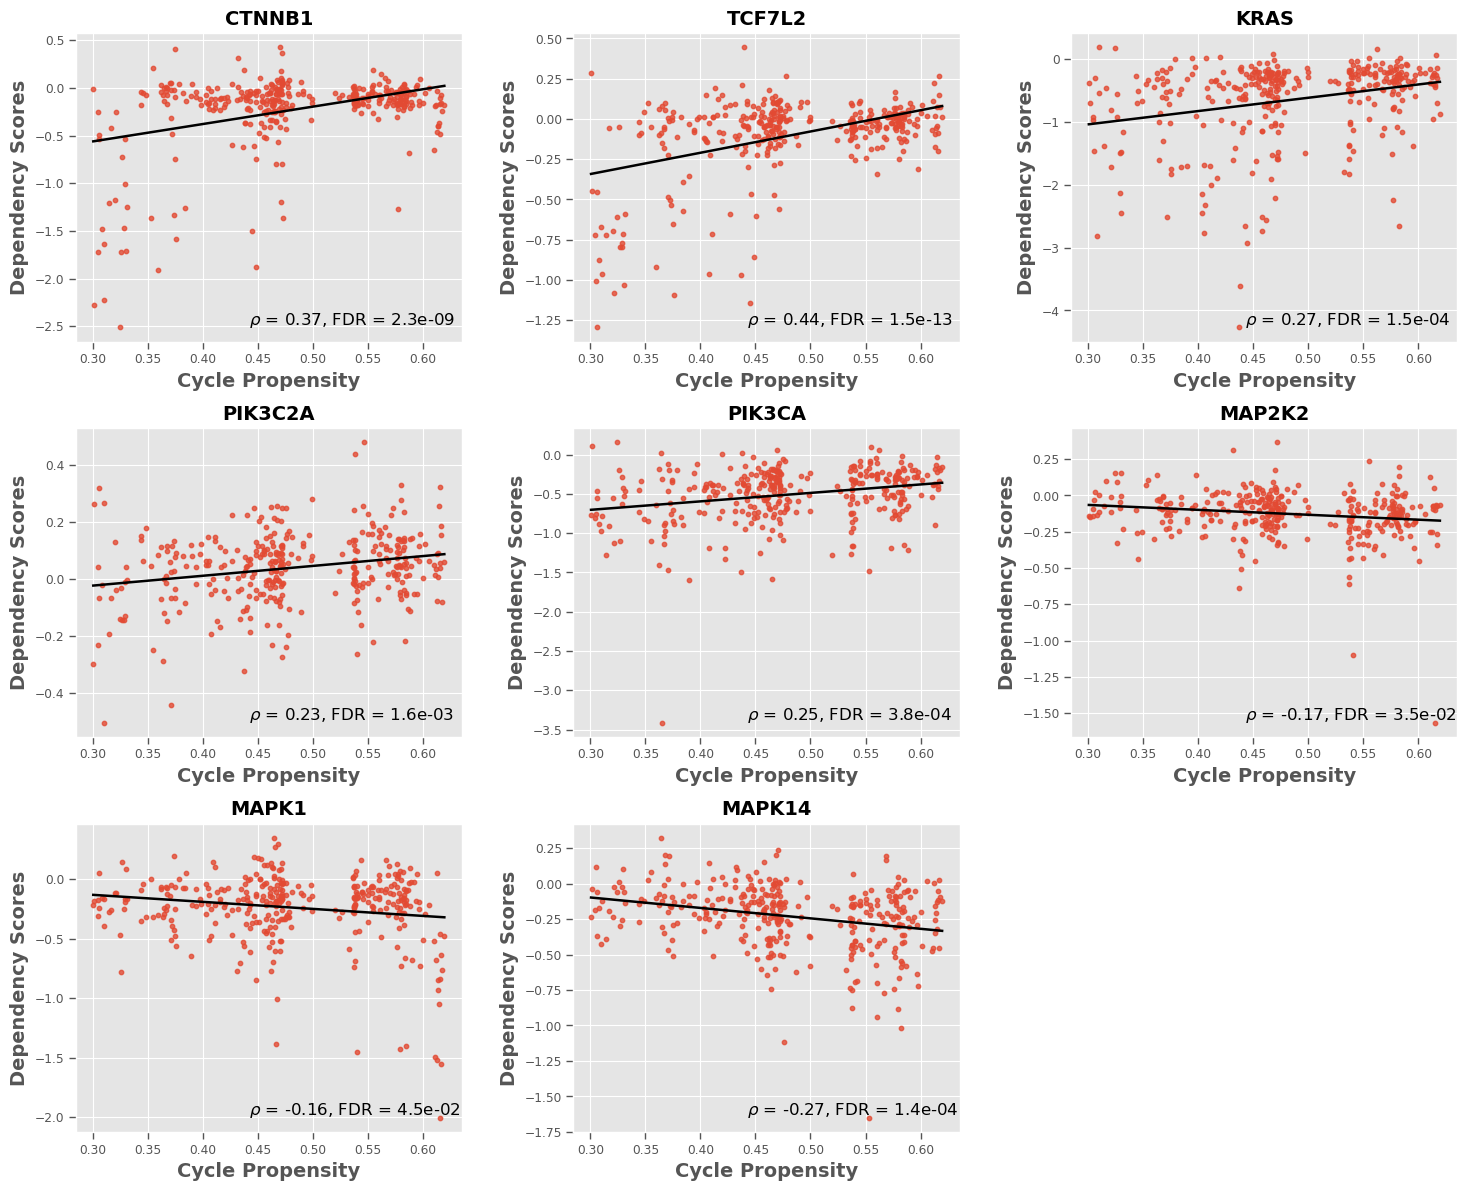

In [16]:
sns.set_context("paper")
n_genes = sens_subset_df.shape[1]
n_cols = 3  # <-- Imposta 3 colonne
n_rows = int(np.ceil(n_genes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Loop sui geni
for i, gene in enumerate(sens_subset_df.columns):
    ax = axes[i]

    # Allineamento e rimozione NaN
    valid_data = pd.concat([propensity, sens_subset_df[gene]], axis=1).dropna()
    valid_data.columns = ["propensity", "gene_value"]

    if not valid_data.empty:
        sns.regplot(
            x=valid_data["propensity"],
            y=valid_data["gene_value"],
            ci=None,
            scatter_kws={'s': 10},
            line_kws={'color': 'black'},
            ax=ax
        )
        ax.set_xlabel("Cycle Propensity", fontsize=14, fontweight='bold')
        ax.set_ylabel("Dependency Scores", fontsize=14, fontweight='bold')
        ax.set_title(gene, fontsize=14, fontweight='bold')

        if gene in propensity_corr_sig.index:
            rho = propensity_corr_sig.loc[gene, "propensity"]
            fdr = propensity_corr_sig.loc[gene, "fdr"]
            ax.text(
                0.45, 0.1,
                f"$\\rho$ = {rho:.2f}, FDR = {fdr:.1e}",
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='top'
            )
    else:
        ax.set_visible(False)

# Rimuove subplot in eccesso
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


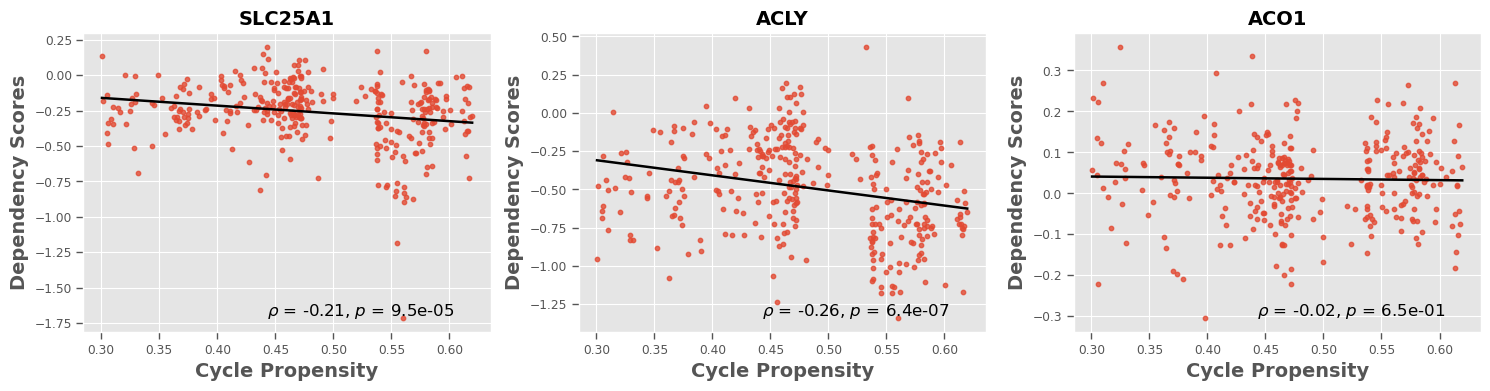

In [17]:
genes = ['SLC25A1', 'ACLY', 'ACO1']
sub_df = sens_df[genes]

sns.set_context("paper")
fig, axes = plt.subplots(1, 3, figsize=(5*3, 4))
axes = axes.flatten()

for ax, gene in zip(axes, genes):
    valid = pd.concat([propensity, sub_df[gene]], axis=1).dropna()
    valid.columns = ["propensity", "gene_value"]

    if not valid.empty:
        sns.regplot(
            x="propensity", y="gene_value",
            data=valid, ci=None,
            scatter_kws={'s':10},
            line_kws={'color':'black'},
            ax=ax
        )
        # calcola rho e p-value
        rho, pval = pearsonr(valid["propensity"], valid["gene_value"])
        ax.text(
            0.45, 0.10,
            f"$\\rho$ = {rho:.2f}, $p$ = {pval:.1e}",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top'
        )
        ax.set_xlabel("Cycle Propensity",   fontsize=14, fontweight='bold')
        ax.set_ylabel("Dependency Scores",fontsize=14, fontweight='bold')
        ax.set_title(gene,                fontsize=14, fontweight='bold')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()
